In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import tensorflow as tf
import numpy as np
import h5py
import datetime
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
%matplotlib inline

In [11]:
import numpy as np
a = np.array([[1,2,3,4,5],[6,7,8,9,10]])
a.T[:2] = 0
a

array([[ 0,  0,  3,  4,  5],
       [ 0,  0,  8,  9, 10]])

In [5]:
f_train = h5py.File("data/TrainEOB_q-1-10-0.02_ProperWhitenZ.h5", "r")
f_test = h5py.File("data/TestEOB_q-1-10-0.02_ProperWhitenZ.h5", "r")

In [6]:
f_train['WhitenedSignals']

<HDF5 dataset "WhitenedSignals": shape (9861, 8192), type "<f8">

In [7]:
np.amax(f_train['m1m2'][...])

75.15116279069767

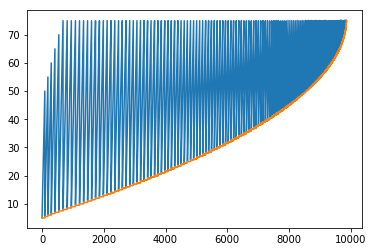

In [8]:
plt.plot(f_train['m1m2'][...].T[0])
plt.plot(f_train['m1m2'][...].T[1])

0:00:00.085030


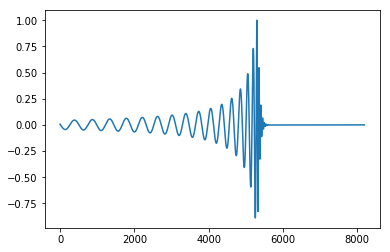

In [9]:
NUM_DATA = f_train['WhitenedSignals'].shape[0]
LENGTH = int(f_train['WhitenedSignals'].shape[1])
def get_batch(f,k,length=LENGTH): 
    batch = []
    label = []
    idx = np.arange(NUM_DATA)
    np.random.shuffle(idx)

    num_batch = NUM_DATA//k
    for i in range(num_batch):
        cur_batch = []
        cur_label = []
        for j in range(k):
            pad = np.random.choice(LENGTH, 1)[0]
            cur_batch.append(np.pad(f['WhitenedSignals'][idx[k*i+j]][:length], 
                                    (0,pad), 'constant', constant_values=0)[pad:])
            cur_label.append(f['m1m2'][idx[k*i+j]])
        batch.append(cur_batch)
        label.append(cur_label) 
        
    batch = np.asarray(batch).reshape(num_batch,k,length,1)
    label = np.asarray(label)
    return batch, label

def get_test(f,k,length=LENGTH):
    batch = []
    label = []
    idx = np.random.choice(f_test['WhitenedSignals'].shape[0], k, replace=False)

    for i in range(k):
        pad = np.random.choice(LENGTH, 1)[0]
        batch.append(np.pad(f['WhitenedSignals'][idx[i]][:length], 
                                    (0,pad), 'constant', constant_values=0)[pad:])
        label.append(f['m1m2'][idx[i]])

    batch = np.asarray(batch).reshape(k,length,1)
    label = np.asarray(label)
    return batch, label

start = datetime.datetime.now()
train_data, train_label = get_test(f_test, 64)
end = datetime.datetime.now()
plt.plot(train_data[0])
print(end-start)

In [10]:
dilation_rates = [2**i for i in range(10)]
receptive_field = sum(dilation_rates)+2
print(receptive_field)

def WaveNet(x):
    length = tf.shape(x)[-1]
    # preprocessing causal layer
    x = tf.layers.conv1d(
        inputs=x,
        filters=16,
        kernel_size=2,
        padding="same")
    
    skips = []

    for dilation_rate in dilation_rates:
        # filter
        x_f = tf.layers.conv1d(
            inputs=x,
            filters=32,
            kernel_size=2,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=tf.nn.tanh)
        
        # gate
        x_g = tf.layers.conv1d(
            inputs=x,
            filters=32,
            kernel_size=2,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=tf.nn.sigmoid)
        
        # element wise multiplication
        z = tf.multiply(x_f,x_g)

        # skip cut to account for receptive field
        skip = tf.slice(z, [0,receptive_field,0], [-1,-1,-1])

        # skip postprocessing
        skip = tf.layers.conv1d(
            inputs=skip,
            filters=128,
            kernel_size=1,
            padding="same")
        
        # residual postprocessing
        z = tf.layers.conv1d(
            inputs=z,
            filters=16,
            kernel_size=1,
            padding="same")
        
        # residual connection
        x = tf.add(x,z)
        
        # skip append
        skips.append(skip)
    
    # add all skip layers and apply activation
    raw = tf.add_n(skips)
    raw = tf.nn.relu(raw)

    # postprocessing
    raw = tf.layers.conv1d(
            inputs=raw,
            filters=128,
            kernel_size=1,
            padding="same",
            activation=tf.nn.relu)
    
    # compress to one channel output
    raw = tf.layers.conv1d(
            inputs=raw,
            filters=1,
            kernel_size=1,
            padding="same")
    
    # max pooling to get k outputs
    #raw = tf.layers.max_pooling1d(raw, (LENGTH-receptive_field)//512, (LENGTH-receptive_field)//512)
    #raw = tf.slice(raw, [0,0,0], [-1,512,-1])
    raw = tf.layers.flatten(raw)
    
    # get k-highest outputs
    values, indices = tf.nn.top_k(raw, 512, False)
    
    values = tf.layers.dense(values, units=1024, activation=tf.nn.relu)
    values = tf.layers.dropout(inputs=values, rate=0.2)
    values = tf.layers.dense(values, units=128, activation=tf.nn.relu)
    values = tf.layers.dropout(inputs=values, rate=0.2)

    #indices = tf.divide(tf.cast(indices, tf.float32), tf.cast(length, tf.float32))
    #indices = tf.layers.dense(indices, units=128, activation=tf.nn.relu)
    #indices = tf.layers.dropout(inputs=indices, rate=0.1)
    #indices = tf.layers.dense(indices, units=128, activation=tf.nn.relu)
    #indices = tf.layers.dropout(inputs=indices, rate=0.1)
    
    #out = tf.multiply(tf.nn.sigmoid(indices), tf.nn.tanh(values))

    out = tf.layers.dense(values, units=2, activation=tf.nn.relu)

    return out

1025


In [11]:
tf.reset_default_graph()

input_data = tf.placeholder(tf.float32, [None, None, 1])
input_label = tf.placeholder(tf.int32, [None,2])
feedlr = tf.placeholder(tf.float32)

# loss function operations
predictions = WaveNet(input_data)
loss = tf.losses.mean_squared_error(input_label, predictions)

# train operation
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(learning_rate=0.001, 
                                           global_step=global_step, 
                                           decay_steps=NUM_DATA//64, 
                                           decay_rate=0.96, 
                                           staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate=feedlr)
train_op = optimizer.minimize(
    loss=loss,
    global_step=global_step)

Instructions for updating:
Use `tf.keras.layers.Conv1D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
init = tf.global_variables_initializer()
saver = tf.train.Saver(tf.trainable_variables())
sess = tf.Session()
sess.run(init)
loss_hist = []
val_loss = []
lrs = []
#saver.restore(sess, "../model/shift.ckpt")

In [17]:
tf.test.is_gpu_available()

True

In [15]:
num_epoch = 50
start = datetime.datetime.now()
batch_size = 4
rate = 0.001
for i in range(num_epoch):
    #cur_len = int(6642*np.exp(-0.005*i)+1550)
    #print('current length of input: '+str(cur_len))
    train_data, train_label = get_batch(f_train, batch_size)
    for j in range(len(train_data)):
        cur_data = train_data[j]
        cur_label = train_label[j]
        _, loss_val = sess.run([train_op, loss],
                           feed_dict={input_data: cur_data,
                                      input_label: cur_label,
                                      feedlr: rate})
        loss_hist.append(loss_val)
        if j % 10 == 0:
            print('loss: '+str(loss_hist[-1]))
    
    val_data, val_label = get_test(f_test, batch_size)
    validation = sess.run(loss, feed_dict={input_data: val_data, input_label: val_label})
    val_loss.append(validation)
    print('iter num: '+str(i)+' loss: '+str(loss_hist[-1])+' val_loss: '+str(val_loss[-1]))

end = datetime.datetime.now()
print('time: '+str(end-start))

UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv1d/conv1d (defined at <ipython-input-10-0b2bebeb183f>:12) ]]
	 [[Adam/update/_108]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv1d/conv1d (defined at <ipython-input-10-0b2bebeb183f>:12) ]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'conv1d/conv1d':
  File "/usr/local/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/usr/local/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/usr/local/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-00c2375bebbf>", line 8, in <module>
    predictions = WaveNet(input_data)
  File "<ipython-input-10-0b2bebeb183f>", line 12, in WaveNet
    padding="same")
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/layers/convolutional.py", line 218, in conv1d
    return layer.apply(inputs)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1479, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/layers/base.py", line 537, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 634, in __call__
    outputs = call_fn(inputs, *args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 146, in wrapper
    ), args, kwargs)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 446, in converted_call
    return _call_unconverted(f, args, kwargs)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 253, in _call_unconverted
    return f(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/convolutional.py", line 373, in call
    return super(Conv1D, self).call(inputs)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/convolutional.py", line 196, in call
    outputs = self._convolution_op(inputs, self.kernel)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py", line 1079, in __call__
    return self.conv_op(inp, filter)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py", line 635, in __call__
    return self.call(inp, filter)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py", line 234, in __call__
    name=self.name)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py", line 223, in _conv1d
    name=name)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 574, in new_func
    return func(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 574, in new_func
    return func(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py", line 1624, in conv1d
    name=name)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1071, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [84]:
save_path = saver.save(sess, "../model/shift.ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: ../model/shift.ckpt


In [85]:
start = 0
end = 8192
pred = []
for i in range(len(f_test['WhitenedSignals'])):
    pad = np.random.choice(LENGTH, 1)[0]
    test_data = np.pad(f_test['WhitenedSignals'][i][start:end], (0,pad), 'constant', constant_values=0)[pad:].reshape(1,end-start,1)
    test_label = f_test['m1m2'][i].reshape(1,2)
    pred.append(sess.run(predictions, feed_dict={input_data: test_data, input_label: test_label})[0])
pred = np.asarray(pred)
test_label = np.asarray(f_test['m1m2'])
m1 = np.mean(np.divide(abs(pred.T[0]-test_label.T[0]),test_label.T[0]))
m2 = np.mean(np.divide(abs(pred.T[1]-test_label.T[1]),test_label.T[1]))
print('start: '+str(start)+' end: '+str(end)+' -- m1: '+str(m1)+' m2: '+str(m2))

start: 0 end: 8192 -- m1: 0.12898739110262897 m2: 0.23928418468140625


In [86]:
start = 0
end = 8192
pred = []
for i in range(len(f_test['WhitenedSignals'])):
    test_data = f_test['WhitenedSignals'][i][start:end].reshape(1,end-start,1)
    test_label = f_test['m1m2'][i].reshape(1,2)
    pred.append(sess.run(predictions, feed_dict={input_data: test_data, input_label: test_label})[0])
pred = np.asarray(pred)
test_label = np.asarray(f_test['m1m2'])
m1 = np.mean(np.divide(abs(pred.T[0]-test_label.T[0]),test_label.T[0]))
m2 = np.mean(np.divide(abs(pred.T[1]-test_label.T[1]),test_label.T[1]))
print('start: '+str(start)+' end: '+str(end)+' -- m1: '+str(m1)+' m2: '+str(m2))

start: 0 end: 8192 -- m1: 0.05005491604426005 m2: 0.07736959794857999


In [13]:
## 0.5s using top_k
start = 0
end = 4096
pred = []
for i in range(len(f_test['WhitenedSignals'])):
    test_data = f_test['WhitenedSignals'][i][start:end].reshape(1,end-start,1)
    test_label = f_test['m1m2'][i].reshape(1,2)
    pred.append(sess.run(predictions, feed_dict={input_data: test_data, input_label: test_label})[0])
pred = np.asarray(pred)
test_label = np.asarray(f_test['m1m2'])
m1 = np.mean(np.divide(abs(pred.T[0]-test_label.T[0]),test_label.T[0]))
m2 = np.mean(np.divide(abs(pred.T[1]-test_label.T[1]),test_label.T[1]))
print('start: '+str(start)+' end: '+str(end)+' -- m1: '+str(m1)+' m2: '+str(m2))

start: 0 end: 4096 -- m1: 0.04367172127205487 m2: 0.05183169236768307


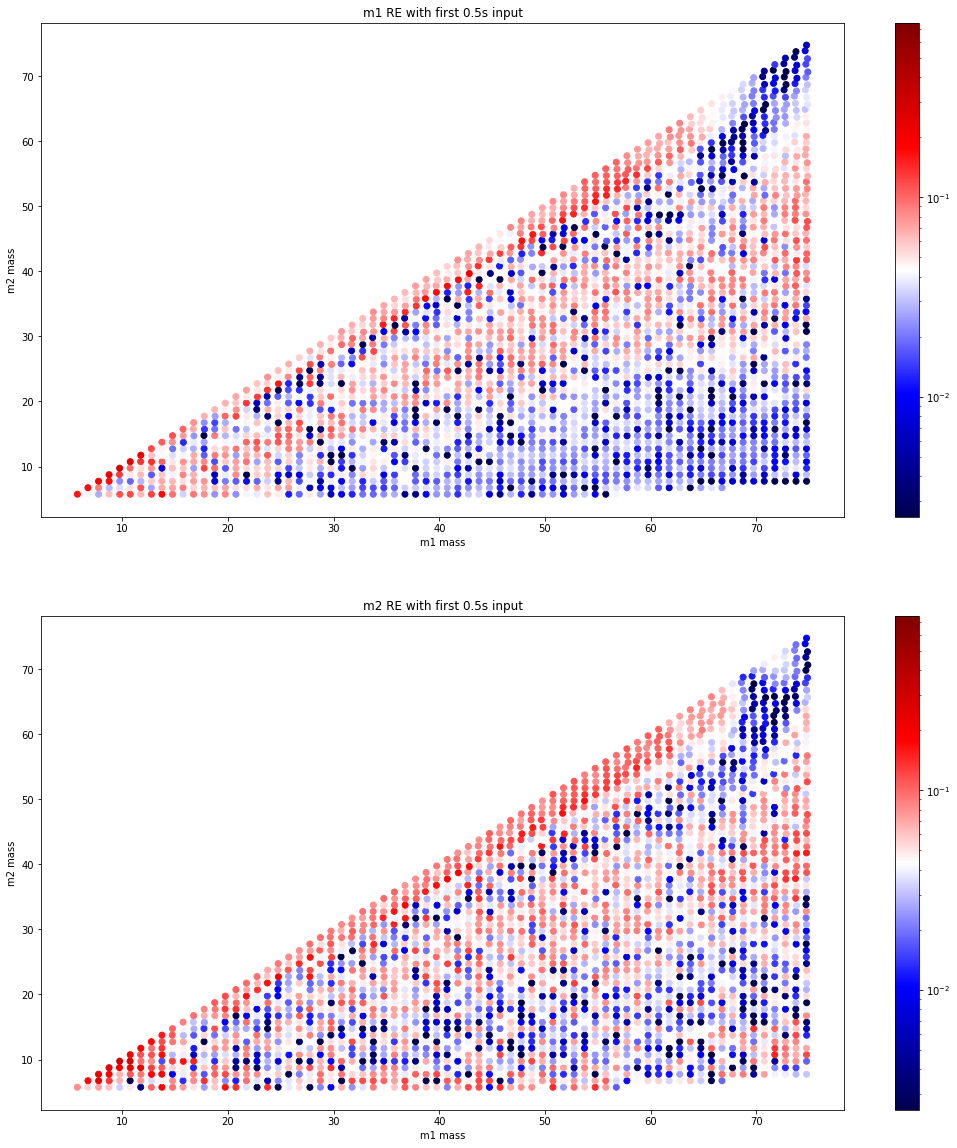

In [179]:
error1 = [abs(pred.T[0][i]-test_label.T[0][i])/test_label.T[0][i] for i in range(len(test_label))]
error2 = [abs(pred.T[1][i]-test_label.T[1][i])/test_label.T[1][i] for i in range(len(test_label))]
plt.figure(figsize=(18,20))
cm = plt.cm.get_cmap('seismic')
plt.subplot(211)
sc = plt.scatter(test_label.T[0], test_label.T[1], c=error1, vmin=0.0025, vmax=0.75, 
                 cmap=cm, norm=colors.LogNorm(vmin=np.amin(error1), vmax=np.amax(error1)))
plt.colorbar(sc)
plt.xlabel('m1 mass')
plt.ylabel('m2 mass')
plt.title('m1 RE with first 0.5s input')
plt.subplot(212)
sc = plt.scatter(test_label.T[0], test_label.T[1], c=error2, vmin=0.0025, vmax=0.75, 
                 cmap=cm, norm=colors.LogNorm(vmin=np.amin(error2), vmax=np.amax(error2)))
plt.colorbar(sc)
plt.xlabel('m1 mass')
plt.ylabel('m2 mass')
plt.title('m2 RE with first 0.5s input')
plt.savefig('half_second.png')

In [165]:
## best for length 0.2s: start at 5860
# best for length 0.22s: 5755 is roughly 0.7s
start = 5761
end = 7563
pred = []
for i in range(len(f_test['WhitenedSignals'])):
    test_data = f_test['WhitenedSignals'][i][start:end].reshape(1,end-start,1)
    test_label = f_test['m1m2'][i].reshape(1,2)
    pred.append(sess.run(predictions, feed_dict={input_data: test_data, input_label: test_label})[0])
pred = np.asarray(pred)
test_label = np.asarray(f_test['m1m2'])
m1 = np.mean(np.divide(abs(pred.T[0]-test_label.T[0]),test_label.T[0]))
m2 = np.mean(np.divide(abs(pred.T[1]-test_label.T[1]),test_label.T[1]))
print('start: '+str(start)+' end: '+str(end)+' -- m1: '+str(m1)+' m2: '+str(m2))

start: 5761 end: 7563 -- m1: 0.017993595633620664 m2: 0.037070486908311884


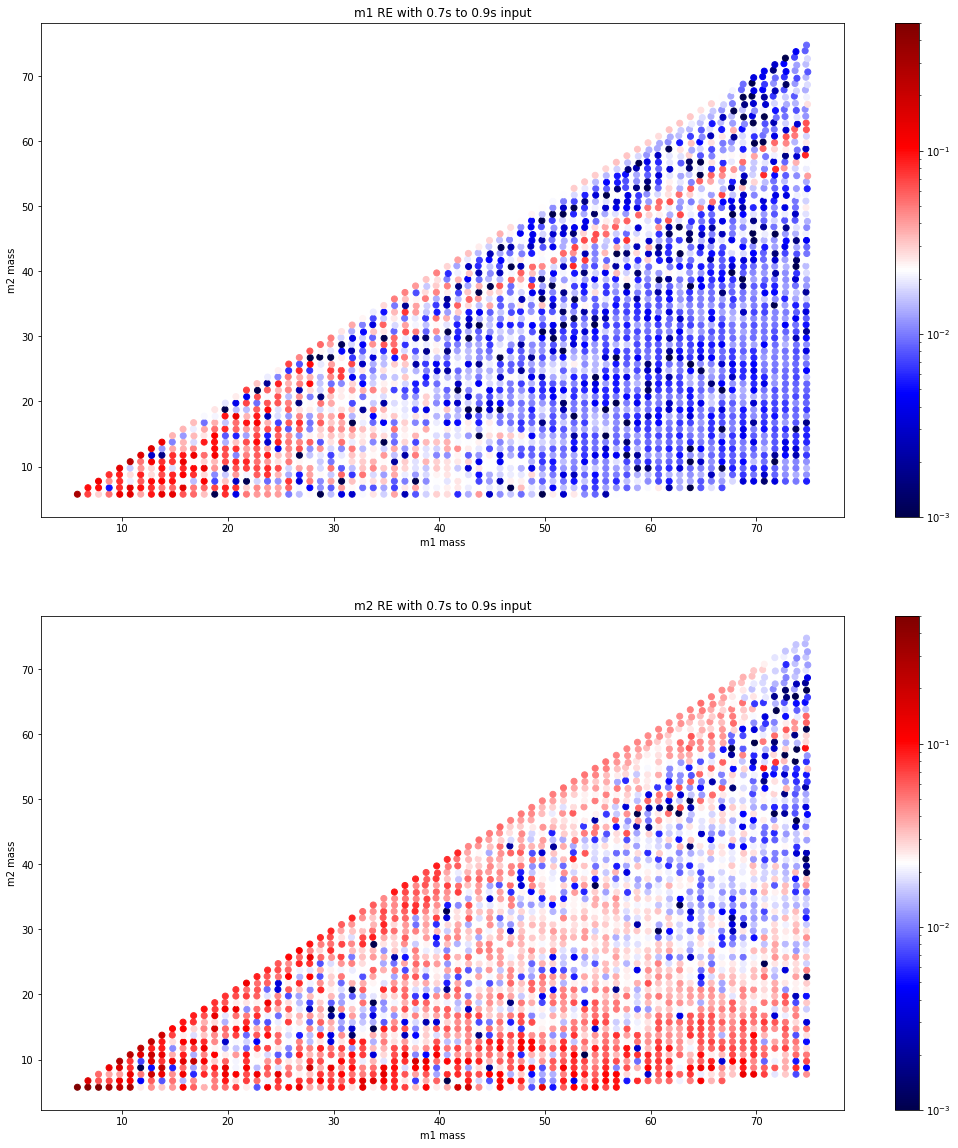

In [43]:
error1 = [abs(pred.T[0][i]-test_label.T[0][i])/test_label.T[0][i] for i in range(len(test_label))]
error2 = [abs(pred.T[1][i]-test_label.T[1][i])/test_label.T[1][i] for i in range(len(test_label))]
plt.figure(figsize=(18,20))
cm = plt.cm.get_cmap('seismic')
plt.subplot(211)
sc = plt.scatter(test_label.T[0], test_label.T[1], c=error1, vmin=0.001, vmax=0.5, 
                 cmap=cm, norm=colors.LogNorm(vmin=np.amin(error1), vmax=np.amax(error1)))
plt.colorbar(sc)
plt.xlabel('m1 mass')
plt.ylabel('m2 mass')
plt.title('m1 RE with 0.7s to 0.9s input')
plt.subplot(212)
sc = plt.scatter(test_label.T[0], test_label.T[1], c=error2, vmin=0.001, vmax=0.5, 
                 cmap=cm, norm=colors.LogNorm(vmin=np.amin(error2), vmax=np.amax(error2)))
plt.colorbar(sc)
plt.xlabel('m1 mass')
plt.ylabel('m2 mass')
plt.title('m2 RE with 0.7s to 0.9s input')
plt.savefig('separate.png')

Text(0.5, 1.0, 'loss and accuracy')

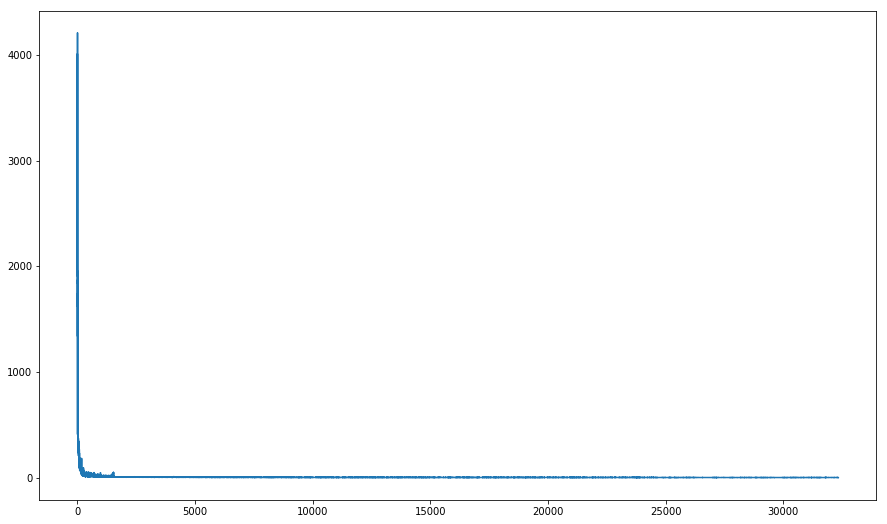

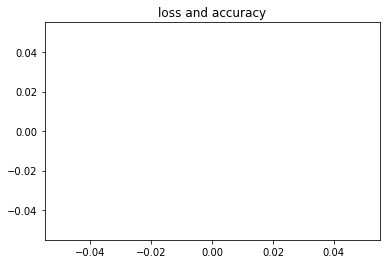

In [24]:
start = 0
length = len(loss_hist) - start
plt.figure(figsize=(15,9))
plt.plot(loss_hist[start:],zorder=1)
#plt.scatter(np.arange(length, step=length//len(val_loss)),val_loss,c='red',zorder=2)
plt.figure()
#plt.plot(lrs[start:])
plt.title('loss and accuracy')

In [22]:
tvars = tf.trainable_variables()
tvars_vals = sess.run(tvars)
for var, val in zip(tvars, tvars_vals):
    print(var.name, val) 

conv1d/kernel:0 [[[ 0.02820369 -0.38729772  0.04878606  0.25884926  0.05906931
   -0.22070795 -0.30404347  0.436573   -0.0224342   0.36892918
   -0.02169633 -0.18246979 -0.00387169 -0.02663426  0.40235683
   -0.11401626]]

 [[-0.02883411  0.16698271  0.3489708   0.1196642   0.33593196
   -0.01394439  0.26637995 -0.37206632  0.16070996 -0.09476986
   -0.09598011 -0.18586497 -0.23128101  0.24714074  0.21544662
   -0.3729777 ]]]
conv1d/bias:0 [-0.00037455  0.08678375 -0.08123148 -0.11365752 -0.13704954  0.08881047
  0.01374818 -0.02558803 -0.05813484 -0.06711501  0.04992128  0.12440601
  0.0852386  -0.08536495 -0.1516853   0.09682617]
conv1d_1/kernel:0 [[[ 0.06004137  0.17041297 -0.05311629 ... -0.04041095 -0.042399
    0.1327065 ]
  [ 0.09940804 -0.04448859  0.07708742 ...  0.18659261  0.16913103
   -0.2045019 ]
  [-0.27516907 -0.10897405 -0.09842873 ...  0.00391032 -0.24263145
    0.11776425]
  ...
  [ 0.2624147   0.2067342  -0.13544968 ... -0.16012113  0.12073392
   -0.03144623]
  [-0.

conv1d_28/kernel:0 [[[ 2.25515962e-01  2.42472231e-01  1.54564366e-01  1.80548891e-01
    2.32083183e-02 -2.11518303e-01  1.95236623e-01  5.34491874e-02
    2.99529701e-01 -3.91612732e-04 -2.36575887e-01 -3.50285411e-01
    1.51133657e-01 -6.28802255e-02 -7.86969289e-02  1.48800742e-02]
  [-3.89814436e-01 -2.56683707e-01  3.72953475e-01 -4.51116145e-01
   -9.33193937e-02 -3.00187618e-01 -4.17218000e-01 -1.25236258e-01
    2.96711903e-02 -3.61065231e-02  2.03724176e-01  2.74080783e-01
   -9.75212231e-02  1.88108847e-01  2.56018877e-01 -8.12617019e-02]
  [ 2.88212925e-01  1.54768884e-01  2.44688123e-01  1.43895432e-01
    4.52632122e-02 -2.45523602e-01 -3.12145740e-01  1.20589346e-01
   -1.69837281e-01  1.14197351e-01 -3.98851901e-01 -1.90433159e-01
   -1.75285921e-01 -3.05075794e-01 -5.25231004e-01  2.86384165e-01]
  [ 2.29257181e-01  7.27381231e-03  3.40476215e-01  2.35942192e-02
    9.91945714e-03  4.12761837e-01  6.57702163e-02 -2.66629279e-01
    6.32901639e-02  3.44090432e-01 -5.08

In [44]:
##predictor2 model
dilation_rates = [2**i for i in range(10)]
receptive_field = sum(dilation_rates)+2
print(receptive_field)

def WaveNet(x):
    length = tf.shape(x)[-1]
    # preprocessing causal layer
    x = tf.layers.conv1d(
        inputs=x,
        filters=16,
        kernel_size=2,
        padding="causal")
    
    skips = []

    for dilation_rate in dilation_rates:
        # filter
        x_f = tf.layers.conv1d(
            inputs=x,
            filters=32,
            kernel_size=2,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=tf.nn.tanh)
        
        # gate
        x_g = tf.layers.conv1d(
            inputs=x,
            filters=32,
            kernel_size=2,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=tf.nn.sigmoid)
        
        # element wise multiplication
        z = tf.multiply(x_f,x_g)

        # skip cut to account for receptive field
        skip = tf.slice(z, [0,receptive_field,0], [-1,-1,-1])

        # skip postprocessing
        skip = tf.layers.conv1d(
            inputs=skip,
            filters=128,
            kernel_size=1,
            padding="same")
        
        # residual postprocessing
        z = tf.layers.conv1d(
            inputs=z,
            filters=16,
            kernel_size=1,
            padding="same")
        
        # residual connection
        x = tf.add(x,z)
        
        # skip append
        skips.append(skip)
    
    # add all skip layers and apply activation
    raw = tf.add_n(skips)
    raw = tf.nn.relu(raw)

    # postprocessing
    raw = tf.layers.conv1d(
            inputs=raw,
            filters=128,
            kernel_size=1,
            padding="same",
            activation=tf.nn.relu)
    
    # compress to one channel output
    raw = tf.layers.conv1d(
            inputs=raw,
            filters=1,
            kernel_size=1,
            padding="same")

    raw = tf.layers.flatten(raw)

    # get k-highest outputs
    values, indices = tf.nn.top_k(raw, 128, False)#512 for half_second
    #values = tf.slice(raw, [0,tf.shape(raw)[-1]-512], [-1,-1])
    values = tf.layers.dense(values, units=1024, activation=tf.nn.relu)
    values = tf.layers.dropout(inputs=values, rate=0.25)#0.1 for half_second
    values = tf.layers.dense(values, units=128, activation=tf.nn.relu)
    values = tf.layers.dropout(inputs=values, rate=0.25)

    #indices = tf.divide(tf.cast(indices, tf.float32), tf.cast(length, tf.float32))
    #indices = tf.layers.dense(indices, units=128, activation=tf.nn.relu)
    #indices = tf.layers.dropout(inputs=indices, rate=0.2)
    
    #out = tf.multiply(tf.nn.sigmoid(indices), tf.nn.tanh(values))

    out = tf.layers.dense(values, units=2, activation=tf.nn.relu)

    return out

tf.reset_default_graph()

input_data = tf.placeholder(tf.float32, [None, None, 1])
input_label = tf.placeholder(tf.int32, [None,2])
feedlr = tf.placeholder(tf.float32)

# loss function operations
predictions = WaveNet(input_data)
loss = tf.losses.mean_squared_error(input_label, predictions)

# train operation
global_step = tf.Variable(0, trainable=False)

optimizer = tf.train.AdamOptimizer(learning_rate=feedlr)
train_op = optimizer.minimize(
    loss=loss,
    global_step=global_step)
init = tf.global_variables_initializer()
saver = tf.train.Saver(tf.trainable_variables())
sess = tf.Session()
sess.run(init)
loss_hist = []
val_loss = []
lrs = []
saver.restore(sess, "../model/predictor2.ckpt")

1025
INFO:tensorflow:Restoring parameters from ../model/predictor2.ckpt
